In [564]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# sklearn utility
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn import metrics   
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()

# Tickers list
# We can add and delete any ticker from the list to get desired ticker live data
ticker_list=['TSLA']

today = date.today()
print(today)
# We can get data by our choice by giving days bracket
start_date= "1997-01-01"
end_date="2019-11-30"

files=[]
def getData(ticker):
    print (ticker)
    if ticker =="^IXIC":
     data = pdr.get_data_yahoo(ticker, start=start_date, end=today)
    else:
     data = pdr.get_data_yahoo(ticker, period = "max",)
    dataname= ticker+'_'+str(today)
    files.append(dataname)
    SaveData(data, dataname)

# Create a data folder in your current dir.
def SaveData(df, filename):
    df.to_csv('D:\\\Daily_Stock_Report\\Stocks'+filename+'.csv')

#This loop will iterate over ticker list, will pass one ticker to get data, and save that data as file.

for tik in ticker_list:
    getData(tik)
    nas = yf.Ticker(tik)

for i in range(0,len(ticker_list)):
    nasdaq = pd.read_csv('D:\\\Daily_Stock_Report\\Stocks'+ str(files[i])+'.csv',index_col='Date', parse_dates=True)
#Copy dataframe NASDAQ
data = nasdaq.copy()


2021-02-28
TSLA
[*********************100%***********************]  1 of 1 completed


In [127]:
nas.info["previousClose"]

3057.16

In [565]:
data = nasdaq.copy()
rolls=16
def preprocessing1(df):
    df['Buy'] = np.zeros(len(df))
    df['Sell'] = np.zeros(len(df))
    df['RSI'] = computeRSI(df['Open'], 13)
    buy_rsi= df[(df['RSI'] < 30) ]
    sell_rsi= df[(df['RSI'] > 70) ]
    hausse= df[(df['Adj Close'] > df['Open'])]
    baisse= df[(df['Adj Close'] < df['Open'])]
    sell_rsi['RSI']=1
    buy_rsi['RSI']=1
    hausse['RSI'] = 1
    baisse['RSI'] = 1 
    df['Hausse']= hausse['RSI']
    df['Baisse']= baisse['RSI']
    df['Baisse']= df[['Baisse']].fillna(0)
    df['Hausse']= df[['Hausse']].fillna(0)
    df['Buy_RSI']= buy_rsi['RSI']
    df['Sell_RSI']= sell_rsi['RSI']
    df['Sell_RSI']= df[['Sell_RSI']].fillna(0)
    df['Buy_RSI']= df[['Buy_RSI']].fillna(0)


    df= df.dropna(subset = ['RSI'])

    return df
def preprocessing(df):


    X = df.drop(['Hausse','Baisse','High','Low','Close','Adj Close'], axis=1)
    y = df['Hausse']
    
    print(y.value_counts())
    
    return X, y

def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi
def evaluate_model_performnce(y_test, y_pred,model):
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualizing model performance
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 

    tn, fp, fn, tp = cm.ravel()
    #print(tn, fp, fn, tp)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = ((tp+tn)/(tp+tn+fp+fn))*100
    print("Precision : ",precision)
    print("Recall : ",recall)
    print("F1 Score : ",f1)
    print("Validation Accuracy : ",accuracy)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy Score : ", accuracy)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print("AUC Value : ", auc)
    N, train_score, val_score = learning_curve(model, X_train, y_train,cv=4, scoring='f1',train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    return accuracy, auc, f1
def make_submission_file(filename, probab, test_id, IdCol, targetCol, threshold=None):
    submit = pd.DataFrame()
    submit[IdCol] = test_id
    submit[targetCol] = probab
    if threshold!=None:
        pred = [1 if x>=threshold else 0 for x in probab]
        #pred1 = np.where(pred==1 , 0, 1)
        submit[targetCol] = pred
    submit.to_csv(filename, index=False)
    return submit
def preproc_last(df):
    df[-1:]['Buy'] = np.zeros(len(df[-1:]))
    df[-1:]['Sell'] = np.zeros(len(df[-1:]))
    df[-1:]['RSI'] = computeRSI(df['Open'], 13)
    buy_rsi= df[(df['RSI'] < 30) ]
    sell_rsi= df[(df['RSI'] > 70) ]
    sell_rsi[-1:]['RSI']=1
    buy_rsi[-1:]['RSI']=1
    df[-1:]['Buy_RSI']= buy_rsi['RSI']
    df[-1:]['Sell_RSI']= sell_rsi['RSI']
    df[-1:]['Sell_RSI']= df[['Sell_RSI']].fillna(0)
    df[-1:]['Buy_RSI']= df[['Buy_RSI']].fillna(0)

    
    return df
#TRAIN DATA	
data= preprocessing1(data)
data['RollingMax'] = data['Close'].shift(1).rolling(window=rolls).max()
data['RollingMin'] = data['Close'].shift(1).rolling(window=rolls).min()
data.loc[data['RollingMax'] < data['Close'], 'Buy'] = 1
data.loc[data['RollingMin'] > data['Close'], 'Sell'] = 1
data['Hold']=(data['Buy'] == 0) & (data['Sell'] == 0)
data= data.dropna(subset = ['RollingMax','RollingMin'])
data=data.loc['1997':'2019']

trainset, testset = train_test_split(data, test_size=0.2, random_state=0)
X_train, y_train = preprocessing(trainset)
X_test , y_test = preprocessing(testset)

data = nasdaq.copy()
data=preprocessing1(data)
data['RollingMax'] = data['Close'].shift(1).rolling(window=rolls).max()
data['RollingMin'] = data['Close'].shift(1).rolling(window=rolls).min()
data.loc[data['RollingMax'] < data['Close'], 'Buy'] = 1
data.loc[data['RollingMin'] > data['Close'], 'Sell'] = 1
data['Hold']=(data['Buy'] == 0) & (data['Sell'] == 0)
data= data.dropna(subset = ['RollingMax','RollingMin'])

preprocessor = make_pipeline(PolynomialFeatures(3, include_bias=False), SelectKBest(f_classif, k=17))
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor,RobustScaler(), AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, RobustScaler(), SVC(random_state=0)) 
KNN = make_pipeline(preprocessor, RobustScaler(), KNeighborsClassifier())
CAT= make_pipeline(preprocessor, RobustScaler(), CatBoostClassifier(verbose=False,random_state=0))
XGB = make_pipeline(preprocessor, RobustScaler(),XGBClassifier(learning_rate= 0.05, n_estimators=60 ,objective= 'binary:logistic',verbosity = 0,nthread=4,seed=42,random_state=0))
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN,
                  'XGB': XGB
                 }

#MODEL GLOBAL
"""st_xgb =XGB
st_lgb = AdaBoostClassifier(random_state=0)
st_cat =LGBMClassifier(random_state=0)

st_clf = StackingClassifier(estimators=[('xgb', st_xgb), ('lgb', st_lgb), ('cat', st_cat)], final_estimator=GradientBoostingClassifier(random_state=0))
st_clf.fit(X_train, y_train)"""

#TEST DATAFRAME TO PREDICT
data.to_csv('test_nasdaq.csv',index=True)
nasdaq_test =  pd.read_csv('test_nasdaq.csv', index_col='Date', parse_dates=True)
nasdaq_test= nasdaq_test.drop(['High','Low','Close','Adj Close','Hausse','Baisse'],axis=1)
nasdaq_test= nasdaq_test.loc['2020':'2021']
#print(nasdaq_test.shape)

nasdaq_real = data.loc['2020':'2021']
nasdaq_real= nasdaq_real[['Hausse']]

#ADD ROW TO PREDICT WITH THE INPUTS
nasdaq_test1= nasdaq_test.copy()
nasdaq_real1= nasdaq_real.copy()
print("----------------  WELCOME TO AI TRADING  -----------------\n")

print('Enter the Open value: ')
 #x_open= input()
x_open= nas.info["previousClose"]
print('Enter the Volume value: ')
 #x_volume= input()
x_volume= nas.info["averageVolume"]

 #print('Enter the date (yyyy-mm-dd): ')
x_date= date.today()

new_row = pd.Series(data={'Open' : float(x_open), 'Volume' : float(x_volume)}, name= x_date)
nasdaq_test1=nasdaq_test1.append(new_row,ignore_index=False)
print('Enter the Hausse value: (0 or 1)')
#x_up= input()
x_up=0

new_row1=pd.Series(data={'Hausse' : float(x_up)},name = x_date)
nasdaq_real1=nasdaq_real1.append(new_row1,ignore_index=False)
#print(nasdaq_test1.tail())

#PREPROCESSING
preproc_last(nasdaq_test1)
nasdaq_test1[-1:]['RollingMax'] = nasdaq_test1['Open'].shift(1).rolling(window=rolls).max()
nasdaq_test1[-1:]['RollingMin'] = nasdaq_test1['Open'].shift(1).rolling(window=rolls).min()
nasdaq_test1.loc[nasdaq_test1['RollingMax'] < nasdaq_test1['Open'], 'Buy'] = 1
nasdaq_test1.loc[nasdaq_test1['RollingMin'] > nasdaq_test1['Open'], 'Sell'] = 1
nasdaq_test1['Hold']=(nasdaq_test1['Buy']==0) & (nasdaq_test1['Sell'] == 0)
#print(nasdaq_test1.tail())

print("--------------------- PREPROCESSING OVER !  ----------------------")
#MODEL TRAIN ON TEST
st_xgb =XGB
st_lgb = CatBoostClassifier(verbose=False,random_state=0)
st_cat =LGBMClassifier(random_state=0)

st_clf = StackingClassifier(estimators=[('xgb', st_xgb), ('lgb', st_lgb), ('cat', st_cat)], final_estimator=XGB)
print(f"MODEL  IS TRAINING AND FIT")

st_clf.fit(X_train, y_train)
print("\nMODEL FITTED")

v_prob = st_clf.predict_proba(nasdaq_test1)
#v_prob= 1 - v_prob 
v_prob = pd.DataFrame(v_prob)[1]

IdCol = 'Date'
targetCol = 'Hausse'
test_id = nasdaq_test1.index

print("---------------- ACCURACY SCORE ---------------------\n")
#ACCURACY SCORE
best_threshold=[]
accuracy=[]
for i in np.arange(0, 1, 0.01):    
    v_sub = make_submission_file("nasdaq_pred_hausse2.csv", v_prob, test_id, IdCol, targetCol, threshold= i)
    v_sub['Good or Not?']=v_sub['Hausse'].reset_index(drop=True) == nasdaq_real1['Hausse'].reset_index(drop=True)
    v_sub[v_sub['Good or Not?']==False].count()[0]
    false_predict= v_sub[v_sub['Good or Not?']==False].count()[0]
    true_predict=v_sub[v_sub['Good or Not?']==True].count()[0]
    #print(true_predict)
    #print(false_predict)    
    accuracy.append(([true_predict/len(nasdaq_real1)*100]))
    best_threshold.append([i])
    
best_acc_thresh= np.concatenate((accuracy,best_threshold),axis=1)
best_threshold_res=np.where(best_acc_thresh == max(accuracy))[0][0]
best_thresh = round(best_acc_thresh[best_threshold_res][1],2)

print(f'Réussite : {max(accuracy)} % avec un Threshold de : {best_thresh}')

v_sub = make_submission_file("nasdaq_pred_hausse2.csv", v_prob, test_id, IdCol, targetCol, threshold=best_thresh)
v_sub['Good or Not?']=v_sub['Hausse'].reset_index(drop=True) == nasdaq_real1['Hausse'].reset_index(drop=True)
false_predict= v_sub[v_sub['Good or Not?']==False].count()[0]
true_predict=v_sub[v_sub['Good or Not?']==True].count()[0]
print(f'Bonnes prédictions: {true_predict}')
print(f'Mauvaises prédictions: {false_predict}')    

v_sub.to_csv('predict_nasdaq2.csv',index=True)
print(v_sub.tail())

0.0    964
1.0    928
Name: Hausse, dtype: int64
1.0    247
0.0    226
Name: Hausse, dtype: int64
----------------  WELCOME TO AI TRADING  -----------------

Enter the Open value: 
Enter the Volume value: 
Enter the Hausse value: (0 or 1)
--------------------- PREPROCESSING OVER !  ----------------------
MODEL  IS TRAINING AND FIT

MODEL FITTED
---------------- ACCURACY SCORE ---------------------

Réussite : [60.61643835616438] % avec un Threshold de : 0.39
Bonnes prédictions: 177
Mauvaises prédictions: 115
          Date  Hausse  Good or Not?
287 2021-02-23       0         False
288 2021-02-24       0         False
289 2021-02-25       0          True
290 2021-02-26       0          True
291 2021-02-28       0          True


In [568]:
v_sub

,Date,Hausse,Good or Not?
0,2020-01-02,0,False
1,2020-01-03,1,True
2,2020-01-06,1,True
3,2020-01-07,1,True
4,2020-01-08,1,True
...,...,...,...
287,2021-02-23,0,False
288,2021-02-24,0,False
289,2021-02-25,0,True
290,2021-02-26,0,True


In [566]:
# Set the initial capital
initial_capital= float(30000.0)
shares=5
percent_nas= data['Close'].divide(nasdaq_test1['Open'])
percent_nas=(1 -percent_nas) * -100 
percent_nas.dropna(inplace=True)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=nasdaq_test1.index).fillna(0.0)
# Buy a 100 shares
positions['Nasdaq'] = (initial_capital / nasdaq_test1['Open']) * v_sub['Hausse'].values 
#positions['Nasdaq'] = shares * v_sub['Hausse'].values 

# Initialize the portfolio with value owned  

positions = positions.mask(positions == 0,(initial_capital / nasdaq_test1['Open']),axis=0) 
#positions = positions.mask(positions == 0,shares) 

portfolio = positions.multiply(nasdaq_test1['Open'], axis=0)


portfolio['Nasdaq']=nasdaq_test1['Open']

portfolio['True?']=v_sub['Good or Not?'].values
# Store the difference in shares owned 
pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(nasdaq_test1['Open'], axis=0)).sum(axis=1)
portfolio.loc[portfolio['Nasdaq'] <= 0, 'Nasdaq'  ] = -portfolio['Nasdaq'] 

portfolio['percent_nas']= percent_nas
# Add `holdings` to portfolio
portfolio.loc[portfolio['percent_nas'] <= 0, 'percent_nas'] = -portfolio['percent_nas'] 

portfolio['gain'] = (portfolio['holdings'].multiply(portfolio['percent_nas'] , axis=0) /100)
portfolio.loc[(portfolio['gain'] <= 0) | (portfolio['gain'] > 0) & (portfolio['True?'] == True), 'gain' ] = (portfolio['holdings'].multiply(portfolio['percent_nas'] , axis=0) /100)
portfolio.loc[ (portfolio['True?'] == False), 'gain' ] = (portfolio['holdings'].multiply(-portfolio['percent_nas'] , axis=0) /100)

# Add `cash` to portfolio

portfolio['total'] = initial_capital + (portfolio['gain'].cumsum(axis=0)) 

#initial_capital=portfolio['total']
# Add `total` to portfolio
portfolio['Buy/Sell']= v_sub['Hausse'].values
# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change() 
if initial_capital>round(portfolio['gain'].cumsum(axis=0)[-2:-1][0],2):
    
 print(f"Gain Total en 1 an : {round(portfolio['gain'].cumsum(axis=0)[-2:-1][0],2)}$ soit {round(portfolio['gain'].cumsum(axis=0)[-2:-1][0]/portfolio['holdings'].mean()*100,2)}%\nEn misant en moyenne {round(portfolio['holdings'].mean(),2)}$")
else: 
 print(f"Gain Total en 1 an : {round(portfolio['gain'].cumsum(axis=0)[-2:-1][0],2)}$ soit {round(portfolio['gain'].cumsum(axis=0)[-2:-1][0]/portfolio['holdings'].mean()*100-100,2)}%\nEn misant en moyenne {round(portfolio['holdings'].mean(),2)}$")

print(f"\nGain Moyen en une journée : {round(portfolio['gain'].mean(axis=0),2)}$")
print(f"\nGain Maximal en une journée : {round(portfolio['gain'].max(axis=0),2)}$")
print(f"\nPerte Maximale en une journée : {round(portfolio['gain'].min(axis=0),2)}$")

# Print the first lines of `portfolio`

portfolio.to_csv("backtest_Nasdaq.csv", index="True")
portfolio

Gain Total en 1 an : 66333.37$ soit 121.11%
En misant en moyenne 30000.0$

Gain Moyen en une journée : 227.95$

Gain Maximal en une journée : 4734.07$

Perte Maximale en une journée : -3045.28$


,Nasdaq,True?,holdings,percent_nas,gain,total,Buy/Sell,returns
Date,,,,,,,,
2020-01-02 00:00:00,84.900002,False,30000.0,1.356891,-407.067281,29592.932719,0,NaN
2020-01-03 00:00:00,88.099998,True,30000.0,0.569806,170.941740,29763.874459,1,0.005776
2020-01-06 00:00:00,88.094002,True,30000.0,2.513221,753.966278,30517.840736,1,0.025332
2020-01-07 00:00:00,92.279999,True,30000.0,1.660162,498.048667,31015.889404,1,0.016320
2020-01-08 00:00:00,94.739998,True,30000.0,3.892763,1167.828886,32183.718290,1,0.037653
...,...,...,...,...,...,...,...,...
2021-02-23 00:00:00,662.130005,False,30000.0,5.544232,-1663.269526,94739.929519,0,-0.017253
2021-02-24 00:00:00,711.849976,False,30000.0,4.238259,-1271.477628,93468.451891,0,-0.013421
2021-02-25 00:00:00,726.150024,True,30000.0,6.049721,1814.916432,95283.368323,0,0.019417


In [533]:
(initial_capital / nasdaq_test1['Open'])

Date
2021-01-04 00:00:00    789.473684
2021-01-05 00:00:00    864.553295
2021-01-06 00:00:00    865.051896
2021-01-07 00:00:00    812.127805
2021-01-08 00:00:00    825.082494
2021-01-11 00:00:00    772.797533
2021-01-12 00:00:00    751.503040
2021-01-13 00:00:00    734.573944
2021-01-14 00:00:00    393.804146
2021-01-15 00:00:00    389.711596
2021-01-19 00:00:00    361.010837
2021-01-20 00:00:00    401.391502
2021-01-21 00:00:00    382.360443
2021-01-22 00:00:00    352.195350
2021-01-25 00:00:00    155.070810
2021-01-26 00:00:00    169.376698
2021-01-27 00:00:00     42.273767
2021-01-28 00:00:00     56.603774
2021-01-29 00:00:00     39.503833
2021-02-01 00:00:00     47.384382
2021-02-02 00:00:00    106.564369
2021-02-03 00:00:00    133.916612
2021-02-04 00:00:00    164.491716
2021-02-05 00:00:00    277.572164
2021-02-08 00:00:00    207.153698
2021-02-09 00:00:00    264.970850
2021-02-10 00:00:00    295.450066
2021-02-11 00:00:00    299.940022
2021-02-12 00:00:00    295.566502
2021-02-1

<Figure size 432x288 with 0 Axes>

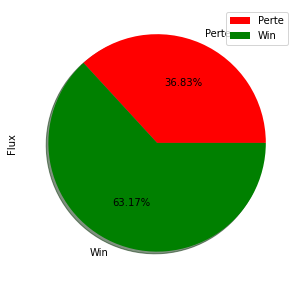

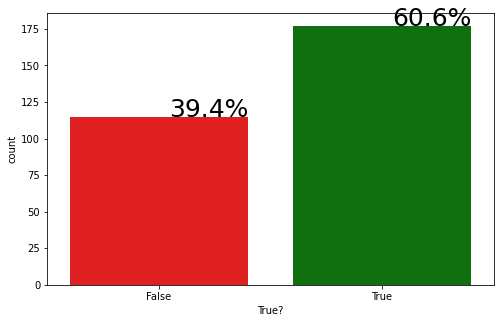

In [567]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

perte=-portfolio['gain'][portfolio['gain'] <=0].cumsum()[-1:]
win=portfolio['gain'][portfolio['gain'] >=0].cumsum()[-1:]
# Plot the equity curve in dollars
df = pd.DataFrame({'Flux': [perte[0], win[0] ]},

                  index=['Perte', 'Win'])

plot = df.plot.pie(y='Flux',shadow=True,autopct="%.2f%%",figsize=(5, 5), colors='rg')
total = float(len(portfolio['True?']))
plt.figure(figsize=(8,5))
ax =sns.countplot(x='True?',data=portfolio,palette=['r',"g"])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right',size=25)
"""ax1.plot(portfolio.loc[portfolio['True?'] == True].index, 
         portfolio.total[portfolio['True?'] == True],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[portfolio['True?'] == False].index, 
         portfolio.total[portfolio['True?'] == False],
         'v', markersize=10, color='k')"""

# Show the plot
plt.show()

In [123]:
portfolio['gain'] = (portfolio['holdings'].multiply(portfolio['percent_nas'] , axis=0) /100)
portfolio.loc[(portfolio['gain'] <= 0) | (portfolio['gain'] > 0) & (portfolio['True?'] == True), 'gain' ] = (portfolio['holdings'].multiply(portfolio['percent_nas'] , axis=0) /100)
portfolio.loc[ (portfolio['True?'] == False), 'gain' ] = (portfolio['holdings'].multiply(-portfolio['percent_nas'] , axis=0) /100)

# Add `cash` to portfolio

portfolio['total'] = initial_capital + (positions.multiply(portfolio['gain'].cumsum(), axis=0)) 

#initial_capital=portfolio['total']
# Add `total` to portfolio

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

print(f"{percent_nas.cumsum(axis=0)[-1]}")


112.51216935945708


In [446]:
data

,Open,High,Low,Close,Adj Close,Volume,Buy,Sell,RSI,Hausse,Baisse,Buy_RSI,Sell_RSI,RollingMax,RollingMin,Hold
Date,,,,,,,,,,,,,,,,
1997-06-05,1.416667,1.541667,1.375000,1.541667,1.541667,5672400,1.0,0.0,20.402497,1.0,0.0,1.0,0.0,1.416667,1.416667,False
1997-06-06,1.515625,1.708333,1.510417,1.656250,1.656250,7807200,1.0,0.0,30.173225,1.0,0.0,0.0,0.0,1.541667,1.541667,False
1997-06-09,1.656250,1.708333,1.656250,1.687500,1.687500,2352000,1.0,0.0,41.271384,1.0,0.0,0.0,0.0,1.656250,1.656250,False
1997-06-10,1.708333,1.708333,1.531250,1.583333,1.583333,5458800,0.0,1.0,44.792061,0.0,1.0,0.0,0.0,1.687500,1.687500,False
1997-06-11,1.593750,1.604167,1.531250,1.541667,1.541667,1188000,0.0,1.0,39.192369,0.0,1.0,0.0,0.0,1.583333,1.583333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,3208.129883,3232.320068,3172.260010,3180.739990,3180.739990,3504600,0.0,1.0,43.674536,0.0,1.0,0.0,0.0,3249.899902,3249.899902,False
2021-02-23,3127.030029,3204.729980,3093.600098,3194.500000,3194.500000,4669500,1.0,0.0,37.627951,1.0,0.0,0.0,0.0,3180.739990,3180.739990,False
2021-02-24,3166.750000,3171.229980,3125.379883,3159.530029,3159.530029,3003000,0.0,1.0,41.896087,0.0,1.0,0.0,0.0,3194.500000,3194.500000,False


In [493]:
# Set the initial capital
initial_capital= float(100000.0)
shares=10
percent_nas= data['Close'].divide(nasdaq_test1['Open'])
percent_nas=(1 -percent_nas) * -100 
percent_nas.dropna(inplace=True)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=nasdaq_test1.index).fillna(0.0)
# Buy a 100 shares
positions['Nasdaq'] = shares * v_sub['Hausse'].values 
# Initialize the portfolio with value owned  
#positions.loc[positions['Nasdaq'] == shares, 'B/S'] = 'Buy'  
#positions.loc[positions['Nasdaq'] == 0, 'B/S'] = 'Sell'
positions = positions.mask(positions == 0,shares) 

portfolio = positions.multiply(nasdaq_test1['Open'], axis=0)


portfolio['Nasdaq']=nasdaq_test1['Open']

portfolio['True?']=v_sub['Good or Not?'].values
# Store the difference in shares owned 
pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(nasdaq_test1['Open'], axis=0)).sum(axis=1)
portfolio.loc[portfolio['Nasdaq'] <= 0, 'Nasdaq'  ] = -portfolio['Nasdaq'] 

portfolio['percent_nas']= percent_nas
# Add `holdings` to portfolio
portfolio.loc[portfolio['percent_nas'] <= 0, 'percent_nas'] = -portfolio['percent_nas'] 
portfolio['Bullish'] = 1
portfolio['Good or Not?']=portfolio['Bullish'] == nasdaq_real1['Hausse']
portfolio['gain'] = (portfolio['holdings'].multiply(portfolio['percent_nas'] , axis=0) /100)
portfolio.loc[(portfolio['gain'] <= 0) | (portfolio['gain'] > 0) & (portfolio['Good or Not?'] == True), 'gain' ] = (portfolio['holdings'].multiply(portfolio['percent_nas'] , axis=0) /100)
portfolio.loc[ (portfolio['Good or Not?'] == False), 'gain' ] = (portfolio['holdings'].multiply(-portfolio['percent_nas'] , axis=0) /100)

# Add `cash` to portfolio

portfolio['total'] = initial_capital + (portfolio['gain'].cumsum(axis=0)) 

#initial_capital=portfolio['total']
# Add `total` to portfolio
portfolio['Buy/Sell']= v_sub['Hausse'].values
# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change() 

print(f"Gain Total en 1 an : {round(portfolio['gain'].cumsum(axis=0)[-2:-1][0],2)}$ soit {round(portfolio['gain'].cumsum(axis=0)[-2:-1][0]/portfolio['holdings'].mean()*100-100,2)}%\nEn misant en moyenne {round(portfolio['holdings'].mean(),2)}$")
print(f"\nGain Moyen en une journée : {round(portfolio['gain'].mean(axis=0),2)}$")
print(f"\nGain Maximal en une journée : {round(portfolio['gain'].max(axis=0),2)}$")
print(f"\nPerte Maximale en une journée : {round(portfolio['gain'].min(axis=0),2)}$")

# Print the first lines of `portfolio`

portfolio.to_csv("backtest_Nasdaq.csv", index="True")
portfolio

Gain Total en 1 an : -2329.83$ soit -108.46%
En misant en moyenne 27546.61$

Gain Moyen en une journée : -8.01$

Gain Maximal en une journée : 1966.4$

Perte Maximale en une journée : -1470.6$


,Nasdaq,True?,holdings,percent_nas,Bullish,Good or Not?,gain,total,Buy/Sell,returns
Date,,,,,,,,,,
2020-01-02 00:00:00,1875.000000,True,18750.000000,1.227201,1,True,230.100098,100230.100098,1,NaN
2020-01-03 00:00:00,1864.500000,True,18645.000000,0.561543,1,True,104.699707,100334.799805,1,0.001045
2020-01-06 00:00:00,1860.000000,True,18600.000000,2.305377,1,True,428.800049,100763.599854,1,0.004274
2020-01-07 00:00:00,1904.500000,True,19045.000000,0.123916,1,True,23.599854,100787.199707,1,0.000234
2020-01-08 00:00:00,1898.040039,False,18980.400391,0.319807,1,False,-60.700684,100726.499023,1,-0.000602
...,...,...,...,...,...,...,...,...,...,...
2021-02-23 00:00:00,3127.030029,False,31270.300293,2.157637,1,True,674.699707,98560.875244,0,0.006893
2021-02-24 00:00:00,3166.750000,False,31667.500000,0.227993,1,False,-72.199707,98488.675537,1,-0.000733
2021-02-25 00:00:00,3136.739990,False,31367.399902,2.537031,1,False,-795.800781,97692.874756,1,-0.008080


In [169]:
portfolio['Buy'].mean()

13773.303090385542

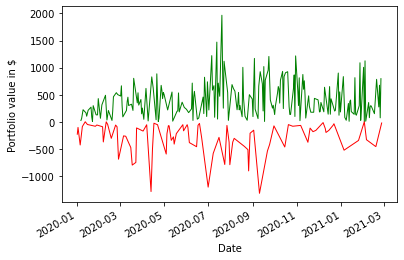

In [305]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['gain'].loc[portfolio['gain'] >=0].plot(ax=ax1, lw=1, color='green')

portfolio['gain'].loc[portfolio['gain'] <=0].plot(ax=ax1, lw=1, color='red')


"""ax1.plot(portfolio.loc[portfolio['True?'] == True].index, 
         portfolio.total[portfolio['True?'] == True],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[portfolio['True?'] == False].index, 
         portfolio.total[portfolio['True?'] == False],
         'v', markersize=10, color='k')"""

# Show the plot
plt.show()

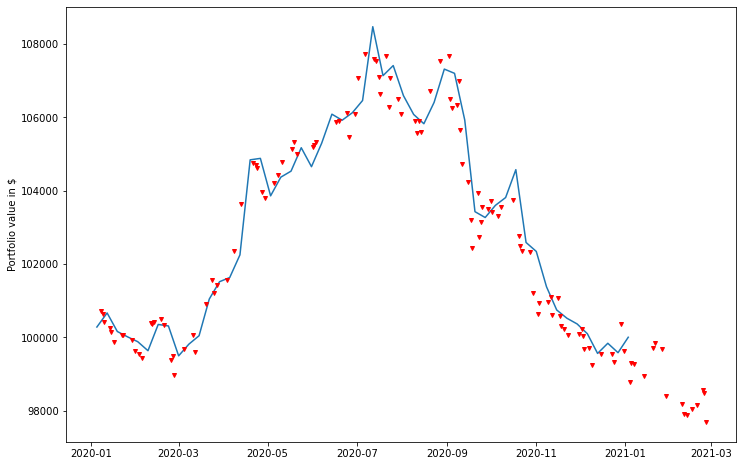

In [494]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure(figsize=(12, 8))
portfolio.index = pd.to_datetime(portfolio.index)
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
ax1.plot(portfolio.loc['2020', 'total'].resample('W').mean())
"""ax1.plot(portfolio.loc[portfolio['True?'] == True].index, 
         portfolio.total[portfolio['True?'] == True],
         '^', markersize=10, color='m')"""
ax1.plot(portfolio.loc[portfolio['True?'] == False].index, 
         portfolio.total[portfolio['True?'] == False],
         'v', markersize=4, color='r')

# Show the plot
plt.show()

<Figure size 432x288 with 0 Axes>

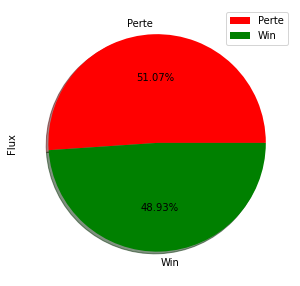

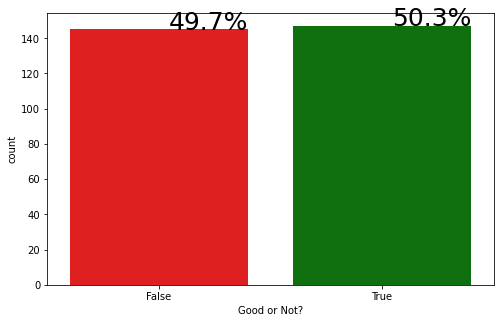

In [496]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

perte=-portfolio['gain'][portfolio['gain'] <=0].cumsum()[-1:]
win=portfolio['gain'][portfolio['gain'] >=0].cumsum()[-1:]
# Plot the equity curve in dollars
df = pd.DataFrame({'Flux': [perte[0], win[0] ]},

                  index=['Perte', 'Win'])

plot = df.plot.pie(y='Flux',shadow=True,autopct="%.2f%%",figsize=(5, 5), colors='rg')
total = float(len(portfolio['Good or Not?']))
plt.figure(figsize=(8,5))
ax =sns.countplot(x='Good or Not?',data=portfolio,palette=['r',"g"])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right',size=25)
"""ax1.plot(portfolio.loc[portfolio['True?'] == True].index, 
         portfolio.total[portfolio['True?'] == True],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[portfolio['True?'] == False].index, 
         portfolio.total[portfolio['True?'] == False],
         'v', markersize=10, color='k')"""

# Show the plot
plt.show()

In [271]:
portfolio.index = pd.to_datetime(portfolio.index)

In [226]:
portfolio['total'] = pd.to_datetime(portfolio['total'])

In [454]:
data.index.day

Int64Index([1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='Date', length=5972)

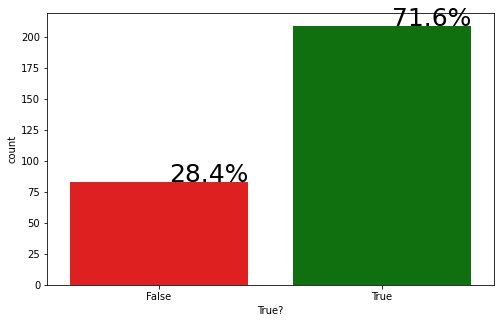

In [442]:
total = float(len(portfolio['True?']))
plt.figure(figsize=(8,5))
ax =sns.countplot(x='True?',data=portfolio,palette=['r',"g"])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right',size=25)
plt.show()

In [476]:
n =289
new_capital=100000
new_capital_baisse=0
new_capital_hausse=0
if percent_nas.any() <=0. :  
   new_capital_baisse=(((portfolio['holdings'] * -percent_nas)))
   if (v_sub['Good or Not?'].item == True) & (v_sub['Hausse'].item == 0 ):
    new_capital+=new_capital_baisse

   elif (v_sub['Good or Not?'].item == False) & (v_sub['Hausse'].item == 0 ):
    new_capital-=new_capital_baisse
else :
  new_capital_hausse=(((portfolio['holdings'] * percent_nas)))
  if  (v_sub['Good or Not?'].item == True) & (v_sub['Hausse'].item == 1 ):
    new_capital+=new_capital_hausse

  elif (v_sub['Good or Not?'].item == False) & (v_sub['Hausse'].item == 1 ):
    new_capital-=new_capital_hausse
#new_capital=initial_capital +new_capital_baisse

print(new_capital)

100000


False

In [326]:
percent_nas= nasdaq_test1['Open'].divide(data['Close'])
percent_nas=(1 -percent_nas) * -100 
percent_nas.dropna(inplace=True)
percent_nas

Date
2020-01-02   -0.579953
2020-01-03   -0.491531
2020-01-06   -1.410683
2020-01-07    0.088874
2020-01-08   -0.670483
                ...   
2021-02-18   -0.365590
2021-02-19    0.394540
2021-02-22    1.338578
2021-02-23   -1.504544
2021-02-24   -1.454039
Length: 289, dtype: float64

In [355]:
v_sub

,Date,Hausse,Good or Not?
0,2020-01-02,1.0,True
1,2020-01-03,1.0,True
2,2020-01-06,1.0,True
3,2020-01-07,0.0,True
4,2020-01-08,1.0,True
...,...,...,...
285,2021-02-19,1.0,False
286,2021-02-22,1.0,False
287,2021-02-23,1.0,True
288,2021-02-24,1.0,True


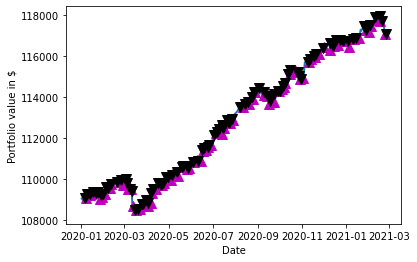

In [299]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[nasdaq_test1.positions == 1.0].index, 
         portfolio.total[nasdaq_test1.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[nasdaq_test1.positions == -1].index, 
         portfolio.total[nasdaq_test1.positions == -1],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

In [ ]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

st_xgb =XGB
st_lgb = CatBoostClassifier(verbose=False,random_state=0)
st_cat =LGBMClassifier(random_state=0)

st_clf = StackingClassifier(estimators=[('xgb', st_xgb), ('lgb', st_lgb), ('cat', st_cat)], final_estimator=XGB)
print(f"MODEL  IS TRAINING AND FIT")

st_clf.fit(X_train, y_train)

In [ ]:
y_pred = st_clf.predict(X_test)
#y_pred= 1- y_pred
st_acc, st_auc, st_f1 = evaluate_model_performnce(y_test, y_pred, st_clf) 


In [ ]:
precision, recall, threshold = precision_recall_curve(y_test, st_clf.decision_function(X_test))

In [ ]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [ ]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

In [ ]:
y_pred = model_final(st_clf, X_test, threshold=-0.1)

In [ ]:
f1_score(y_test, y_pred)

In [ ]:
data

In [203]:
import glob
import os
import pandas as pd
path = r'C:\Users\asus\nasdaq_predict'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
dict_val1=[]
k=290
best_score={}
best_score= pd.DataFrame(best_score,columns=['VoteIA(%)','Flux','True?'])
n=1
dropy=0
nb_file=0
while n < 291:
    dict_val1=[]
    
    for f in all_files:
     df_from_each_file = (pd.read_csv(f,index_col='Date', parse_dates=True) )
     df= pd.DataFrame(df_from_each_file)
        
     if (df['accuracy'][0] <= 71 ) :
      #df['accuracy']= df[df['accuracy'] >= 70]
      #df.drop(df[df['accuracy']<=70].index,inplace=True)
      dropy+=1
      continue
     df1= df.iloc[-n:k]
     #print(df1['Hausse'][0])
     lol=df1['Hausse'].values
     dict_val1.append(lol)
    k-=1
    dict_val1=pd.DataFrame(dict_val1, columns=[df1.index])
    #dict_val1=dict_val1.reshape(len(dict_val1),1)
    #dict_val1=dict_val1.loc[55:]
    baisse=dict_val1[dict_val1[df1.index]==0].count()
    hausse=dict_val1[dict_val1[df1.index]==1].count()
    if df['accuracy'].empty != True: 
     if (round(baisse[0]/len(dict_val1)*100,2)) >=59:
         #print(f"Attention !\nBaisse prédite le {df1.index[0]} à {round(baisse[0]/len(dict_val1)*100,2)}% sur {len(dict_val1)} IA calibrées à 80% de réussite au minimum")

         new_rown = pd.Series(data={'VoteIA(%)' : (round(baisse[0]/len(dict_val1)*100,2)), 'Flux' : 0},name=df1.index[0])
         best_score=best_score.append(new_rown,ignore_index=False)
     elif (round(hausse[0]/len(dict_val1)*100,2)) >=41:
         #print(f"Nice !\nHausse prédite à {round(hausse[0]/len(dict_val1)*100,2)}% sur {len(dict_val1)} IA calibrées à 80% de réussite au minimum")

         new_rown = pd.Series(data={'VoteIA(%)' : (round(hausse[0]/len(dict_val1)*100,2)), 'Flux' : 1},name=df1.index[0])
         best_score=best_score.append(new_rown,ignore_index=False)
     del dict_val1
     n+=1
    else:
     del dict_val1
     n+=1
     pass
print("\n-------------- Before Shift with the Expert ----------------\n")

print(f"Nb restant d'IA après drop: {(100-(dropy/290))}")

best_score['real']=nasdaq_real['Hausse']
best_score['real'][0]=0
best_score['True?']=best_score['Flux'] == best_score['real']
false_predict1= best_score[best_score['True?']==False].count()[0]
true_predict1=best_score[best_score['True?']==True].count()[0]
print(f'Bonnes prédictions: {true_predict1}')
print(f'Mauvaises prédictions: {false_predict1}') 
print(f"Réussite : {true_predict1/df.shape[0]*100}")
best_score.tail()
best_score.to_csv('predict_VoteIA.csv',index=True)
print(best_score)

print("\n-------------- Shift with the Expert ----------------\n")
file_best_IA = (pd.read_csv(r"C:\Users\asus\nasdaq_predict\predict_nasdaq16.csv",index_col='Date', parse_dates=True) )
df_best_IA= pd.DataFrame(file_best_IA)
best_score['True? Best IA'] = df_best_IA['Good or Not?']
best_score1 = best_score[(best_score['VoteIA(%)'] <73.7) & (best_score['True?'] ==False) & (best_score['True? Best IA'] ==True) ]
best_score['Flux']=best_score[['Flux']].mask((best_score['VoteIA(%)'] <73.7) & (best_score['True?'] ==False) & (best_score['True? Best IA'] ==True),1)
best_score['Flux']=best_score[['Flux']].mask((best_score['VoteIA(%)'] <73.7) & (best_score['True?'] ==False) & (best_score['True? Best IA'] ==True),0)

best_score['True?']=best_score['Flux'] == best_score['real']
false_predict1= best_score[best_score['True?']==False].count()[0]
true_predict1=best_score[best_score['True?']==True].count()[0]
print(f'Bonnes prédictions: {true_predict1}')
print(f'Mauvaises prédictions: {false_predict1}') 
print(f"Réussite : {true_predict1/df.shape[0]*100}")
best_score.to_csv('predict_VoteIA_Expert.csv',index=True)

print(best_score)



-------------- Before Shift with the Expert ----------------

Nb restant d'IA après drop: 9.0
Bonnes prédictions: 226
Mauvaises prédictions: 64
Réussite : 77.93103448275862
            VoteIA(%)  Flux  True?  real
2021-02-25      77.78   0.0   True   0.0
2021-02-24     100.00   0.0  False   1.0
2021-02-23      55.56   1.0   True   1.0
2021-02-22      77.78   0.0   True   0.0
2021-02-19      66.67   0.0   True   0.0
...               ...   ...    ...   ...
2020-01-08     100.00   1.0   True   1.0
2020-01-07     100.00   0.0   True   0.0
2020-01-06      44.44   1.0   True   1.0
2020-01-03      66.67   0.0  False   1.0
2020-01-02     100.00   1.0   True   1.0

[290 rows x 4 columns]

-------------- Shift with the Expert ----------------

Bonnes prédictions: 231
Mauvaises prédictions: 59
Réussite : 79.65517241379311


,VoteIA(%),Flux,True?,real,True? Best IA
2021-02-25,77.78,0.0,True,0.0,True
2021-02-24,100.00,0.0,False,1.0,False
2021-02-23,55.56,1.0,True,1.0,True
2021-02-22,77.78,0.0,True,0.0,True
2021-02-19,66.67,0.0,True,0.0,True
...,...,...,...,...,...
2020-01-08,100.00,1.0,True,1.0,True
2020-01-07,100.00,0.0,True,0.0,True
2020-01-06,44.44,1.0,True,1.0,False
2020-01-03,66.67,0.0,False,1.0,True


In [137]:
false_predict1= best_score[best_score['True?']==False].count()[0]
true_predict1=best_score[best_score['True?']==True].count()[0]
print(f'Bonnes prédictions: {true_predict1}')
print(f'Mauvaises prédictions: {false_predict1}') 
true_predict1/df.shape[0]*100

Bonnes prédictions: 236
Mauvaises prédictions: 54


81.37931034482759

In [198]:
file_best_IA = (pd.read_csv(r"C:\Users\asus\nasdaq_predict\predict_nasdaq16.csv",index_col='Date', parse_dates=True) )
df_best_IA= pd.DataFrame(file_best_IA)
best_score['True? Best IA'] = df_best_IA['Good or Not?']
best_score1 = best_score[(best_score['VoteIA(%)'] <73.7) & (best_score['True?'] ==False) & (best_score['True? Best IA'] ==True) ]
best_score['Flux']=best_score[['Flux']].mask((best_score['VoteIA(%)'] <73.7) & (best_score['True?'] ==False) & (best_score['True? Best IA'] ==True),1)
best_score['True?']=best_score['Flux'] == best_score['real']
false_predict1= best_score[best_score['True?']==False].count()[0]
true_predict1=best_score[best_score['True?']==True].count()[0]
print(f'Bonnes prédictions: {true_predict1}')
print(f'Mauvaises prédictions: {false_predict1}') 
print(f"Réussite : {true_predict1/df.shape[0]*100}")
best_score1

Bonnes prédictions: 230
Mauvaises prédictions: 60
Réussite : 79.3103448275862


,VoteIA(%),Flux,True?,real,True? Best IA


In [105]:
if (df['accuracy'][0] <= 70 ) :
 df['accuracy']= df[df['accuracy'] >= 70]
 df.dropna(inplace=True)

In [179]:
df['accuracy']

Series([], Name: accuracy, dtype: float64)

In [154]:
df['accuracy'].empty

True

In [ ]:
for i in np.arange(0, 1, 0.01):    
    pred = [1 if x>=i else 0 for x in baisse]
    best_score['VoteIA(%)'] = pred
    best_score['True?']=best_score['Flux'] == best_score['real']
    false_predict1= best_score[best_score['True?']==False].count()[0]
    true_predict1=best_score[best_score['True?']==True].count()[0]
    print(f'Bonnes prédictions: {true_predict1}')
    print(f'Mauvaises prédictions: {false_predict1}')  
    accuracy.append(([true_predict/len(nasdaq_real)*100]))
    best_threshold.append([i])

best_acc_thresh= np.concatenate((accuracy,best_threshold),axis=1)
best_threshold_res=np.where(best_acc_thresh == max(accuracy))[0][0]
best_thresh = round(best_acc_thresh[best_threshold_res][1],2)

print(f'Réussite : {max(accuracy)} % avec un Threshold de : {best_thresh}')

In [569]:
best_score[(best_score['VoteIA(%)'] <90) & (best_score['Flux'] ==1)  ].sort_values(by='VoteIA(%)' )

NameError: name 'best_score' is not defined

In [145]:
print(best_score)

            VoteIA(%)  Flux  True?  real  True? Best IA
2021-02-25       80.0   1.0  False   NaN           True
2021-02-24       63.0   1.0   True   1.0          False
2021-02-23       71.0   1.0   True   1.0           True
2021-02-22       66.0   0.0   True   0.0           True
2021-02-19       68.0   0.0   True   0.0           True
...               ...   ...    ...   ...            ...
2020-01-08       99.0   1.0   True   1.0           True
2020-01-07       98.0   0.0   True   0.0           True
2020-01-06       64.0   1.0   True   1.0          False
2020-01-03       66.0   1.0   True   1.0           True
2020-01-02       99.0   1.0   True   1.0           True

[290 rows x 5 columns]


In [133]:
best_score['True?']=best_score['Flux'] == best_score['real']


In [130]:
file_best_IA = (pd.read_csv(r"C:\Users\asus\nasdaq_predict\predict_nasdaq16.csv",index_col='Date', parse_dates=True) )
df_best_IA= pd.DataFrame(file_best_IA)

best_score['True? Best IA'] = df_best_IA['Good or Not?']
best_score1 = best_score[(best_score['VoteIA(%)'] <73.7) & (best_score['True?'] ==False) & (best_score['True? Best IA'] ==True) ]
best_score['Flux']=best_score[['Flux']].mask((best_score['VoteIA(%)'] <73.7) & (best_score['True?'] ==False) & (best_score['True? Best IA'] ==True),0)
best_score['True?']=best_score['Flux'] == best_score['real']


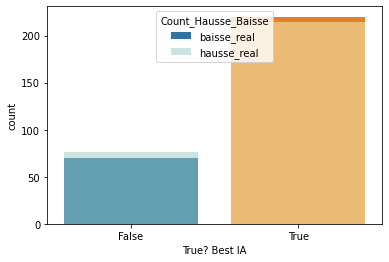

In [80]:


plt.figure()
sns.countplot(x= 'True?', data=best_score)
sns.countplot(x= 'True? Best IA', data=best_score,palette="Set3", alpha=0.5)
plt.legend(('baisse_real','hausse_real','baisse_predict','hausse_predict'),title='Count_Hausse_Baisse',loc='upper center')

In [ ]:
for n in range(17,24) : 
    real_predict= (concatenated_df['Good or Not?'].loc[f'2021-02-{n}'] ==  True)
    k=0
    dict_val=[]
    for index, value in real_predict.items():
        for i in range(0,len(real_predict)):
         if i == 0:
            k+=1
            if value == True:
             dict_val.append(k)
    print(index, dict_val)
    print(n)
print(index, dict_val)


In [ ]:
real_predict= (concatenated_df['Good or Not?'].loc[f'2021-02-19'] ==  True)
k=0
dict_val=[]
for index, value in real_predict.items():
    for i in range(0,len(real_predict)):
     if i == 0:
        k+=1
        if value == True:
         dict_val.append(k)
print(index, dict_val)


In [ ]:
print(index, dict_val)
dict_val[10:20]

In [195]:
k=0
dict_val1=[]
truedict=[]
num_days=28
df_last = pd.read_csv(r'C:\Users\asus\nasdaq_predict\predict_nasdaq16.csv',index_col='Date', parse_dates=True)
for i in range(num_days,len(df_last['Good or Not?']),num_days):
  dict_val1.append(df_last['Good or Not?'][k:i])
  k+=num_days
#print(dict_val1)
for l in range(0,len(dict_val1)):
    truedict.append((((dict_val1[l]==True).sum()) / num_days)*100)
print(f"La Reussite totale moyenne  : {np.mean(truedict)}")
print(f"La Reussite (sur une région de {num_days} jours) max : {np.max(truedict)}")
print(f"La Reussite (sur une région de {num_days} jours) min : {np.min(truedict)}")
print(truedict)
        

La Reussite totale moyenne  : 73.92857142857142
La Reussite (sur une région de 28 jours) max : 89.28571428571429
La Reussite (sur une région de 28 jours) min : 60.71428571428571
[60.71428571428571, 71.42857142857143, 64.28571428571429, 89.28571428571429, 75.0, 82.14285714285714, 75.0, 78.57142857142857, 64.28571428571429, 78.57142857142857]


In [ ]:
import numpy as np
import glob
import os
import pandas as pd
path = r'C:\Users\asus\nasdaq_predict'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f,index_col='Date', parse_dates=True) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=False)
k=287
dict_val1=[]
truedict=[]

best_score = {"Reussite(%)":[],"Flux":[],"Date":[]};

n=287
while n > 280:
    dict_val1=[]

    for i in range(1,int(len(concatenated_df['Hausse'])/n)):
      dict_val1.append(concatenated_df['Hausse'][(n*i)-1:n*i])
      
    dict_val2= pd.DataFrame(dict_val1)
    if (100-round(np.sum(dict_val1)/len(dict_val1)*100,2)) <=50:
     print(f"Attention !\nBaisse prédite à {100-round(np.sum(dict_val1)/len(dict_val1)*100,2)}% sur {len(dict_val1)} IA calibrées à 80% de réussite au minimum")
     best_score["Reussite(%)"].append(100-round(np.sum(dict_val1)/len(dict_val1)*100,2))
     best_score["Flux"].append("Baisse")
     best_score["Date"].append(concatenated_df.index[n])
    else :
     print(f"Nice !\nHausse prédite à {100-round(np.sum(dict_val1)/len(dict_val1)*100,2)}% sur {len(dict_val1)} IA calibrées à 80% de réussite au minimum")
     best_score["Reussite(%)"].append(100-round(np.sum(dict_val1)/len(dict_val1)*100,2))
     best_score["Flux"].append("Hausse")
     best_score["Date"].append(concatenated_df.index[n])

    del dict_val1
    n-=1
best_score= pd.DataFrame(best_score)
best_score.head()
#for l in range(0,len(dict_val1)):
  #print((dict_val1[l] == 1).cumsum())
#print(f"La Reussite totale moyenne  : {np.mean(truedict)}")
#print(f"La Reussite (sur une région de {num_days} jours) max : {np.max(truedict)}")
#print(f"La Reussite (sur une région de {num_days} jours) min : {np.min(truedict)}")
#print(truedict)
        

In [ ]:
(100-round(np.sum(dict_val1)/len(dict_val1)*100,2))

In [ ]:
dict_val1['2021-02-23']

In [ ]:
df_last = pd.read_csv('C:\Users\asus\nasdaq_predict\predict_nasdaq53.csv',index_col='Date', parse_dates=True)

In [ ]:
print((dict_val1[0]==True).sum())
print(dict_val1[0])